# 5-PSI Segmentation Analysis in Python

## Setup

Import all neccessary packages; create function to open and crop image simultaneously.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#scikit-image imports
import skimage.util as skutil
import skimage.io as io
import skimage.exposure as expo
from skimage.filters import threshold_otsu
from skimage import img_as_int #to convert to 8-bit uint
#Open/Crop Image
def openimage(image):
    I8 = io.imread(image).astype(np.float32)
#    I8 = img_as_ubyte(io.imread(image)) #Image as UINT8
    return I8[1:4380, 1:6250] #Crop Image [1 1 6250 4380]
    #imwrite(I8, '01-18 Original_Cropped.tif', 'compression', 'none')


Collect original image, use function to produce cropped image from the correct path. This block of code rescales the intensities of the image and subtracts the image, preparing it for thresholding.

After subtraction, image is thresholded usinbg automatic Otsu method.

In [2]:
#Grab original image
cropped = openimage(os.path.join(os.path.abspath('..'), 'data', '9psi_1.tiff'))

#Adjust Image with range of intensities
p1, p2 = np.percentile(cropped, (5, 99.994))
Iadj = expo.rescale_intensity(cropped, in_range=(p1,p2))

#Get Background Image
bgimg = openimage(os.path.join(os.path.abspath('..'), 'data', '9psi_baseline.tiff'))
p3, p4 = np.percentile(bgimg, (0,100))
bgadj = expo.rescale_intensity(bgimg, in_range = (p1,p2))

#Subtract Image and Invert
isubt = np.subtract(cropped, bgimg)

isubt = skutil.invert(isubt)

#Threshold Image
threshed = threshold_otsu(isubt)
binary = isubt > threshed

Shows Original Image, Adjusted Image, Background Image.

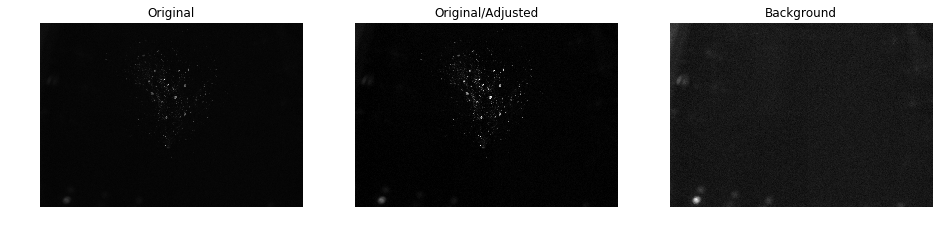

In [3]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
ax = axes.ravel()
    
ax[0].imshow(cropped, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(Iadj, cmap=plt.cm.gray)
ax[1].set_title('Original/Adjusted')
ax[1].axis('off')
#    ax[1].hist(isubt.ravel(), bins=40)
#    ax[1].set_title('Histogram')
#    ax[1].axvline(threshed, color='r')
    
ax[2].imshow(bgimg,cmap=plt.cm.gray)
ax[2].set_title('Background')
ax[2].axis('off')

plt.show()

Subtracted and Thresholded Image produced.

In [ ]:
fig2, axes2 = plt.subplots(ncols=2, figsize=(16, 10))
ax2 = axes2.ravel()

ax2[0].imshow(isubt, cmap=plt.cm.gray)
ax2[0].set_title('Subtracted')
ax2[0].axis('off')

ax2[1].imshow(binary, cmap=plt.cm.gray)
ax2[1].set_title('Thresholded')
ax2[1].axis('off')
print('Threshold value: ' + str(threshed))
plt.show()

Interactive version of final thresholded image.

In [ ]:
%matplotlib inline
fig3, ax3 = plt.subplots(figsize=(10,10))

ax3.imshow(binary, cmap=plt.cm.gray)
ax3.set_title('Segmented')
ax3.axis('off') #Turns off axis for image

plt.show()

Properly convert to float (-1 to 1) image array for skimage package to read.

In [4]:
from skimage import img_as_ubyte
float_isubt = expo.rescale_intensity(isubt)
float_isubt = img_as_ubyte(float_isubt)

/home/james/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Morphological closing on an image is defined as a dilation followed by an erosion. Closing can remove dark spots (i.e. pepper") and connect small bright cracks. This tends to "close" up (dark) gaps between bright features. This block of code imports the neccessary algorithms required to produce the results above by using the binary_closing method.

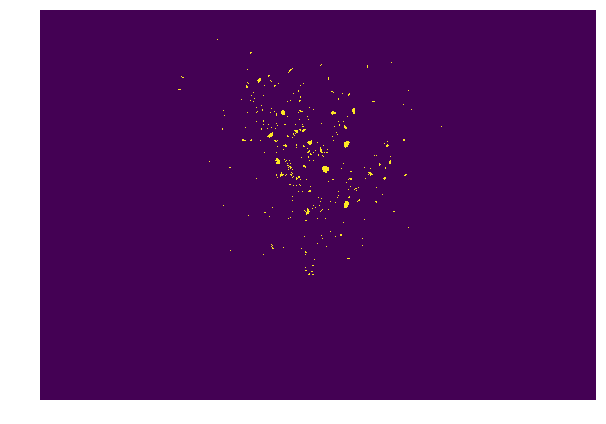

In [6]:
%matplotlib inline
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, square
from skimage.color import label2rgb

bw = binary_closing(isubt > threshed, square(3))
bw = skutil.invert(bw)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(bw)

ax.set_axis_off()
plt.tight_layout()
plt.show()

This labels the entire image after closing process.

In [ ]:
#cleared = clear_border(bw)
#ax.imshow(cleared)
label_image = label(bw)
image_label_overlay = label2rgb(label_image, image=float_isubt)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

ax.set_axis_off()
plt.tight_layout()
plt.show()

Rectangular labels placed on every fragment greater than 100 pixels. Number of fragments, and number of fragments greater than 100 pixels included.

In [ ]:
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

n_fragments = 0
n_fragments_1 = 0
for region in regionprops(label_image):
    # take regions with large enough areas
    n_fragments += 1
    if region.area >= 100:
        n_fragments_1 += 1
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

print(n_fragments)
print(n_fragments_1)

ax.set_axis_off()
plt.tight_layout()
plt.savefig('Closed-Labelled.tif')
plt.show()

These are the labels and fragments without going through the morphological closing process.

In [7]:
binary_inverted = skutil.invert(binary)
label_image_2 = label(binary_inverted)

image_label_overlay_2 = label2rgb(label_image_2, image=float_isubt)

In [ ]:
%matplotlib inline

#fig, ax = plt.subplots(figsize=(10, 6))
#ax.imshow(image_label_overlay)
#print(binary)

#ax.set_axis_off()
#plt.tight_layout()
#plt.show()

fig3, axes3 = plt.subplots(ncols=2, figsize=(16, 10))
ax3 = axes3.ravel()

ax3[0].imshow(image_label_overlay_2)
ax3[0].set_title('Color Labeled')
ax3[0].axis('off')

ax3[1].imshow(binary, cmap=plt.cm.gray)
ax3[1].set_title('Original Thresholded')
ax3[1].axis('off')
plt.tight_layout()
plt.show()

In [8]:
%matplotlib inline
import matplotlib.patches as mpatches
n2_fragments = 0
n2_fragments_1 = 0

#fig5, ax5 = plt.subplots(figsize=(10, 6))
#ax5.imshow(image_label_overlay_2)

#####
dpi = 80
height, width, nbands = image_label_overlay_2.shape
figsize = width / float(dpi), height / float(dpi)

fig5 = plt.figure(figsize=figsize)
ax5 = fig5.add_axes([0,0,1,1])
print(ax5)
ax5.axis('off')
ax5.imshow(image_label_overlay_2)#, interpolation='nearest')

#####

for region in regionprops(label_image_2):
    # take regions with large enough areas
    n2_fragments += 1
    if region.area >= 100:
        n2_fragments_1 += 1
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax5.add_patch(rect)

print(n2_fragments)
print(n2_fragments_1)
####
plt.savefig('Binary-Labelled2.tif', dpi=dpi, transparent=True)

####

#ax5.set_axis_off()
#plt.savefig('Binary-Labelled.tif')
#plt.tight_layout()
#plt.show()

Axes(0,0;1x1)
1046
172


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
